In [ ]:
!pip install ctgan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.8/73.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 81.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
 

In [ ]:
from ctgan import CTGAN
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np

# 1. ĐỌC & TIỀN XỬ LÝ DỮ LIỆU GỐC
df_real = pd.read_csv('/content/processed_iot_dataset_full.csv')

sensor_cols = [
    'Temperature', 'Vibration', 'Pressure', 'Voltage', 'Current',
    'FFT_Feature1', 'FFT_Feature2', 'Anomaly_Score'
]
time_cols = [col for col in ['Year', 'Month', 'Day', 'Hour', 'Minute'] if col in df_real.columns]
sensor_id_col = 'Sensor_ID'

# Lọc Sensor_ID hợp lệ (100-200, đúng như data gốc)
valid_sensor_ids = df_real[
    (df_real[sensor_id_col] >= 100) & (df_real[sensor_id_col] <= 200)
][sensor_id_col].unique()
df_real = df_real[df_real[sensor_id_col].isin(valid_sensor_ids)]

# 2. CHUẨN HÓA MINMAX CHO GAN
scaler = MinMaxScaler()
df_real_scaled = df_real.copy()
df_real_scaled[sensor_cols] = scaler.fit_transform(df_real[sensor_cols])

# 3. SINH DỮ LIỆU CTGAN CHO CÁC FAULT_TYPE CẦN BỔ SUNG
n_sample = 5000
synthetic = []

for fault_type in [1, 2, 3]:
    print(f"- Sinh dữ liệu cho Fault_Type = {fault_type}")
    df_ft = df_real_scaled[df_real_scaled['Fault_Type'] == fault_type].reset_index(drop=True)
    # Giữ Sensor_ID hợp lệ
    df_ft = df_ft[df_ft[sensor_id_col].isin(valid_sensor_ids)].reset_index(drop=True)
    categorical_cols = [
        col for col in df_ft.columns
        if (df_ft[col].dtype == 'object' or df_ft[col].nunique() < 20)
        and col not in time_cols + ['Fault_Type']
    ]
    train_cols = [col for col in df_ft.columns if col not in time_cols]
    ctgan = CTGAN(epochs=200)
    ctgan.fit(df_ft[train_cols], categorical_cols)
    synth = ctgan.sample(n_sample)
    synth['Fault_Type'] = fault_type
    synth[sensor_id_col] = np.random.choice(valid_sensor_ids, size=n_sample, replace=True)
    # Gán lại time_cols (nếu có)
    for col in [c for c in time_cols if c in df_ft]:
        synth[col] = np.random.choice(df_ft[col], size=n_sample, replace=True)
    # Đưa về giá trị gốc
    synth[sensor_cols] = scaler.inverse_transform(synth[sensor_cols])
    # Loại bỏ giá trị âm, 0, >1
    for col in sensor_cols:
        synth[col] = synth[col].apply(lambda x: x if (x > 0 and x <= 1) else np.nan)
    synth = synth.dropna(subset=sensor_cols)
    # Đảm bảo Sensor_ID hợp lệ
    synth = synth[synth[sensor_id_col].isin(valid_sensor_ids)]
    synthetic.append(synth)

df_gan = pd.concat(synthetic, ignore_index=True)
df_gan.to_csv('/content/ctgan_synthetic_optimized.csv', index=False)


- Sinh dữ liệu cho Fault_Type = 1
- Sinh dữ liệu cho Fault_Type = 2
- Sinh dữ liệu cho Fault_Type = 3


In [ ]:
# Đọc file dữ liệu gốc và file GAN đã sinh
df_real = pd.read_csv('/content/processed_iot_dataset_full.csv')
df_gan = pd.read_csv('/content/ctgan_synthetic_optimized.csv')

sensor_cols = [
    'Temperature', 'Vibration', 'Pressure', 'Voltage', 'Current',
    'FFT_Feature1', 'FFT_Feature2', 'Anomaly_Score'
]

print(f"{'Sensor':<15} | {'Min Real':<12} | {'Max Real':<12} | {'Min GAN':<12} | {'Max GAN':<12}")
print('-'*68)
for col in sensor_cols:
    min_real = df_real[col].min()
    max_real = df_real[col].max()
    min_gan = df_gan[col].min()
    max_gan = df_gan[col].max()
    print(f"{col:<15} | {min_real:<12.5f} | {max_real:<12.5f} | {min_gan:<12.5f} | {max_gan:<12.5f}")


Sensor          | Min Real     | Max Real     | Min GAN      | Max GAN     
--------------------------------------------------------------------
Temperature     | 0.21281      | 0.87239      | 0.13169      | 0.92122     
Vibration       | 0.20682      | 0.82428      | 0.16476      | 0.89640     
Pressure        | 0.13089      | 0.77761      | 0.05066      | 0.83470     
Voltage         | 0.20626      | 0.86649      | 0.11604      | 0.93495     
Current         | 0.19854      | 0.82317      | 0.12503      | 0.89020     
FFT_Feature1    | 0.00004      | 0.99998      | 0.00006      | 0.99997     
FFT_Feature2    | 0.00003      | 0.99999      | 0.00022      | 1.00000     
Anomaly_Score   | 0.00002      | 1.00000      | 0.00000      | 0.99975     


In [ ]:
# 4. GỘP VỚI DỮ LIỆU GỐC, SẮP XẾP THEO THỜI GIAN
time_sort_cols = [col for col in ['Year', 'Month', 'Day', 'Hour', 'Minute'] if col in df_real.columns]
df_merged = pd.concat([df_real, df_gan], ignore_index=True)
df_merged = df_merged.drop_duplicates().sort_values(time_sort_cols).reset_index(drop=True)
df_merged.to_csv('/content/full_dataset_with_gan_optimized.csv', index=False)

In [ ]:
# IN SỐ LƯỢNG
print(f"\nSố lượng dữ liệu gốc: {len(df_real)}")
print(f"Số lượng dữ liệu GAN sinh ra: {len(df_gan)}")
print(f"Số lượng sau khi ghép: {len(df_merged)}")


Số lượng dữ liệu gốc: 48302
Số lượng dữ liệu GAN sinh ra: 12735
Số lượng sau khi ghép: 61037


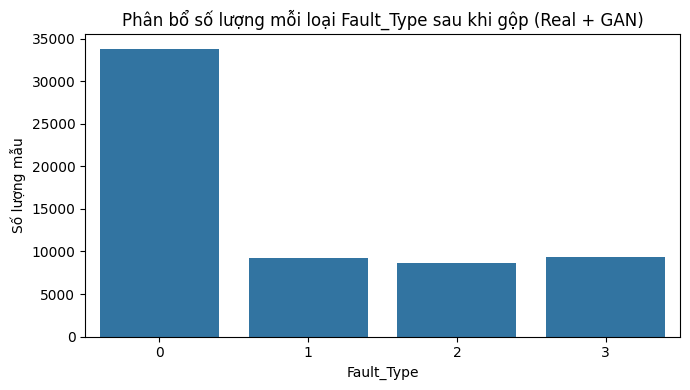

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Tính số lượng mỗi loại lỗi (Fault_Type)
fault_counts = df_merged['Fault_Type'].value_counts().sort_index()

plt.figure(figsize=(7,4))
sns.barplot(x=fault_counts.index.astype(str), y=fault_counts.values)
plt.xlabel('Fault_Type')
plt.ylabel('Số lượng mẫu')
plt.title('Phân bổ số lượng mỗi loại Fault_Type sau khi gộp (Real + GAN)')
plt.tight_layout()
plt.show()


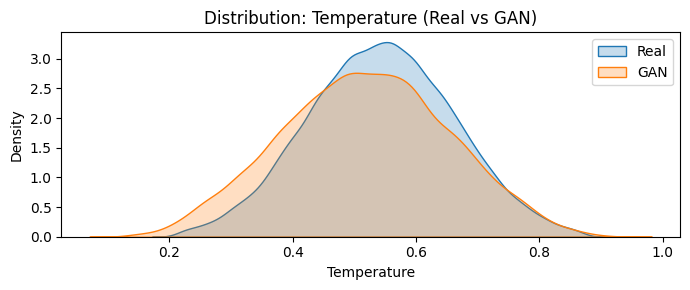

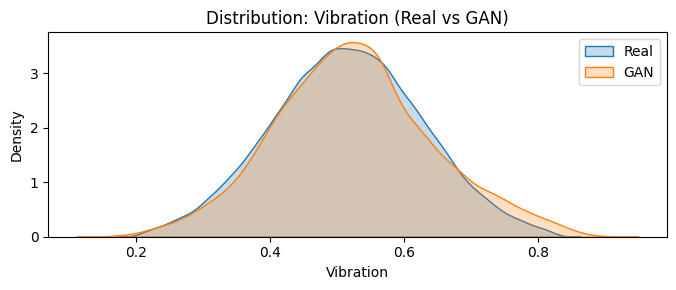

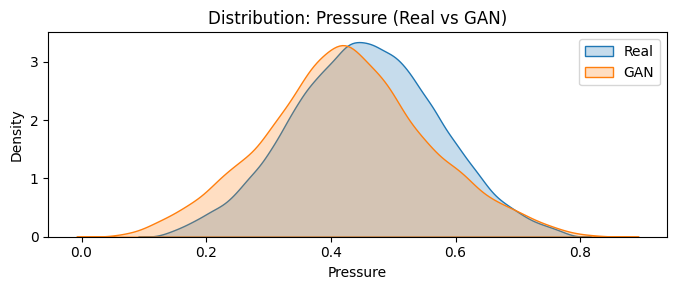

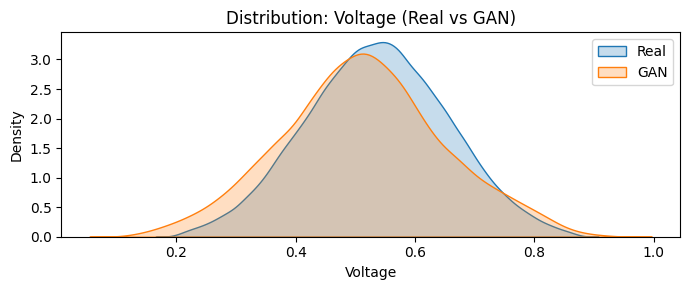

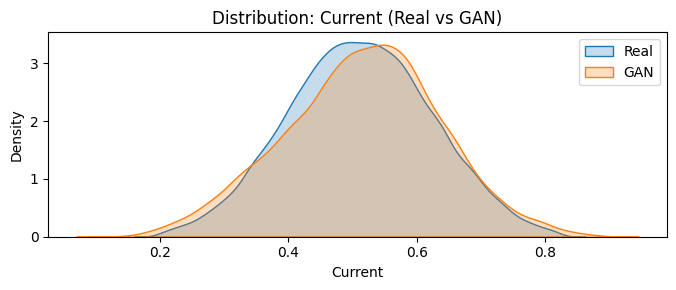

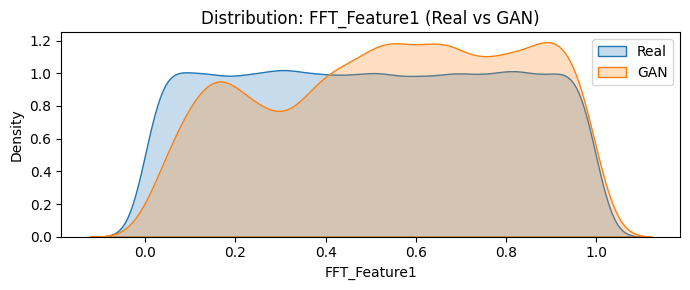

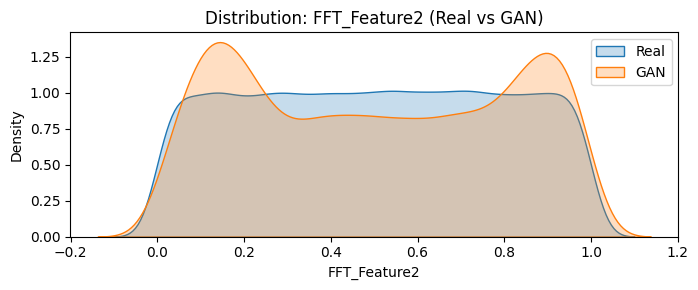

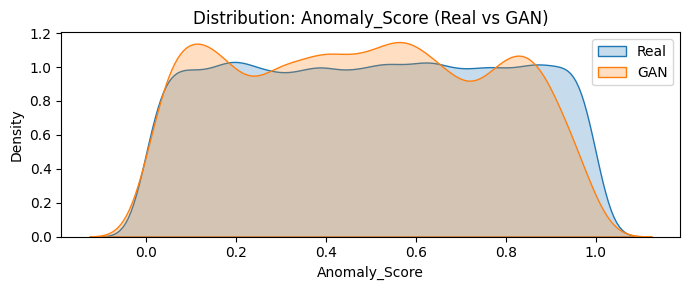

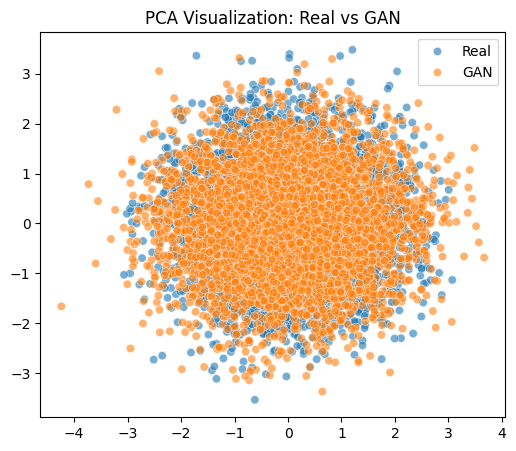

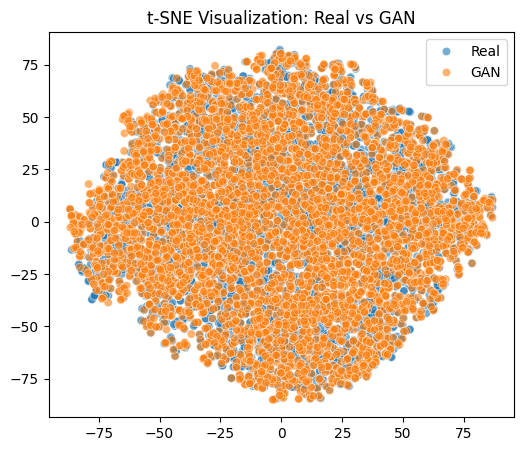


=== KL & JS Divergence between Real and GAN Data ===
      Feature  KL_Divergence  JS_Divergence
  Temperature       0.032441       0.008719
    Vibration       0.010292       0.002724
     Pressure       0.039683       0.010286
      Voltage       0.031229       0.008105
      Current       0.010786       0.002746
 FFT_Feature1       0.037863       0.008411
 FFT_Feature2       0.028672       0.007236
Anomaly_Score       0.023115       0.005219


In [ ]:
# 5. PHÂN TÍCH & TRỰC QUAN HÓA
import pandas as pd
import numpy as np
from ctgan import CTGAN
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import jensenshannon
from scipy.stats import entropy
## 5.1. So sánh phân phối từng feature (Distribution)
for col in sensor_cols:
    plt.figure(figsize=(7,3))
    sns.kdeplot(df_real[col], label='Real', fill=True)
    sns.kdeplot(df_gan[col], label='GAN', fill=True)
    plt.title(f'Distribution: {col} (Real vs GAN)')
    plt.legend()
    plt.tight_layout()
    plt.show()

## 5.2. PCA & t-SNE (lấy sample nhỏ để t-SNE nhanh)
n_vis = 5000
real_idx = np.random.choice(df_real.index, size=min(n_vis, len(df_real)), replace=False)
gan_idx = np.random.choice(df_gan.index, size=min(n_vis, len(df_gan)), replace=False)
real_scaled = StandardScaler().fit_transform(df_real.loc[real_idx, sensor_cols])
gan_scaled = StandardScaler().fit_transform(df_gan.loc[gan_idx, sensor_cols])
combined = np.vstack([real_scaled, gan_scaled])
labels = np.array(['Real'] * len(real_idx) + ['GAN'] * len(gan_idx))

# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(combined)
plt.figure(figsize=(6, 5))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=labels, alpha=0.6)
plt.title("PCA Visualization: Real vs GAN")
plt.show()

# t-SNE
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
tsne_result = tsne.fit_transform(combined)
plt.figure(figsize=(6, 5))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=labels, alpha=0.6)
plt.title("t-SNE Visualization: Real vs GAN")
plt.show()

## 5.3. KL & JS Divergence
def compute_kl_js(real, fake):
    kl_div = entropy(real + 1e-9, fake + 1e-9)
    js_div = jensenshannon(real + 1e-9, fake + 1e-9) ** 2
    return kl_div, js_div

results = []
for col in sensor_cols:
    real_hist, bins = np.histogram(df_real[col], bins=50, range=(df_real[col].min(), df_real[col].max()), density=True)
    fake_hist, _ = np.histogram(df_gan[col], bins=bins, density=True)
    kl, js = compute_kl_js(real_hist, fake_hist)
    results.append({"Feature": col, "KL_Divergence": kl, "JS_Divergence": js})

div_df = pd.DataFrame(results)
print("\n=== KL & JS Divergence between Real and GAN Data ===")
print(div_df.to_string(index=False))

